<a href="https://colab.research.google.com/github/Cristie-Lima/FruitsVeggies_ML_Aplicada1/blob/main/Projeto_Final_FruitsVeggies_v2_7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Projeto Final ‚Äì Classifica√ß√£o de Frutas, Legumes e Verduras (v2.7.2)**  
**Base te√≥rica:** Kelleher, John D.; Mac Namee, Brian; D‚ÄôArcy, Aoife (2020). *Fundamentals of Machine Learning for Predictive Data Analytics (2nd ed.).*

> **Equipe:** A. Cristiane R. Lima; Claudio Sampaio;

> [parece que Felipe Botero entrou em outro grupo;

> Jos√© Henrique Cavalcante apresentou dia 11.out (s√°bado) ao Prof. F√°bio]




# üîß 0. Prepara√ß√£o dos dados ‚Äî **limpeza opcional** vs. **atualiza√ß√£o de timestamps** (v2.6)

Para controlar de forma segura a prepara√ß√£o das pastas `train/`, `validation/` e `test/`, introduz-se um **par√¢metro** que permite escolher entre:

- **`mode = "touch"` (recomendado / n√£o destrutivo):** apenas **atualiza os timestamps** (`mtime/atime`) de todos os arquivos, **sem apagar nada**. √ötil quando se deseja for√ßar a ordena√ß√£o/rec√™ncia sem reextrair os dados.
- **`mode = "reextract"` (destrutivo e completo):** **remove** o conte√∫do das pastas e **reextrai** os arquivos diretamente de `train.zip`, `validation.zip` e `test.zip` (se presentes). Garante consist√™ncia total, mas √© mais custoso.

> **Sugest√£o:** utilizar `mode = "touch"` como padr√£o (mais seguro para n√£o corromper o dataset), e recorrer a `reextract` quando houver suspeita de estrutura incorreta ou res√≠duos.


> **Atualiza√ß√£o (v2.7):** adota-se um par√¢metro de execu√ß√£o com dois modos ‚Äî `mode = "touch"` (atualiza timestamps, **n√£o destrutivo**) e `mode = "reextract"` (limpa e reextrai dos ZIPs, **destrutivo**); e uma *flag* `dry_run = True` para simula√ß√£o sem altera√ß√µes.

In [ ]:

# @title Prepara√ß√£o dos dados ‚Äî modo 'touch' (seguro) ou 'reextract' (completo) + DRY RUN
import os, time, shutil

# === CONFIGURA√á√ÉO ===
BASE_DIR_DATA = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies"  # local dos zips e das pastas train/validation/test
mode = "touch"        # op√ß√µes: "touch" (n√£o destrutivo) | "reextract" (destrutivo)
dry_run = False       # True: simula sem alterar; False: executa

splits = ["train", "validation", "test"]
zip_paths = {s: os.path.join(BASE_DIR_DATA, f"{s}.zip") for s in splits}

def touch_all(root):
    now = time.time(); total = 0
    for subdir, _, files in os.walk(root):
        for f in files:
            fp = os.path.join(subdir, f)
            if dry_run:
                print("[DRY] tocaria:", fp); total += 1; continue
            try:
                os.utime(fp, (now, now)); total += 1
            except Exception as e:
                print("Erro utime:", fp, e)
    return total

def clean_and_reextract(base_dir):
    for s in splits:
        target = os.path.join(base_dir, s)
        if os.path.exists(target):
            if dry_run: print(f"[DRY] removeria: {target}")
            else: shutil.rmtree(target)
        if dry_run: print(f"[DRY] criaria: {target}")
        else: os.makedirs(target, exist_ok=True)
    for s in splits:
        zpath = zip_paths[s]; target = os.path.join(base_dir, s)
        if os.path.exists(zpath):
            cmd = f'unzip -q "{zpath}" -d "{target}"'
            if dry_run: print(f"[DRY] executaria:", cmd)
            else:
                exit_code = os.system(cmd)
                if exit_code != 0: print(f"‚ö†Ô∏è Falha ao extrair {zpath} (exit={exit_code})")
        else:
            print(f"‚ö†Ô∏è ZIP n√£o encontrado para {s}: {zpath}")

print("BASE_DIR_DATA:", BASE_DIR_DATA, "| mode:", mode, "| dry_run:", dry_run)
if mode == "touch":
    total = 0
    for s in splits:
        folder = os.path.join(BASE_DIR_DATA, s)
        if not os.path.isdir(folder):
            print("‚ö†Ô∏è Pasta inexistente (pulando):", folder); continue
        total += touch_all(folder)
    print(f"‚úÖ Conclu√≠do ‚Äî timestamps {'(simulados) ' if dry_run else ''}atualizados em {total:,} arquivos.")
elif mode == "reextract":
    clean_and_reextract(BASE_DIR_DATA)
    print(f"‚úÖ Conclu√≠do ‚Äî pastas {'(simuladas) ' if dry_run else ''}limpas e {'(simuladas) ' if dry_run else ''}reextra√≠das dos ZIPs.")
else:
    print("‚ö†Ô∏è Modo inv√°lido. Use 'touch' ou 'reextract'.")


BASE_DIR_DATA: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies | mode: touch | dry_run: False
‚ö†Ô∏è Pasta inexistente (pulando): /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train
‚ö†Ô∏è Pasta inexistente (pulando): /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/validation
‚ö†Ô∏è Pasta inexistente (pulando): /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/test
‚úÖ Conclu√≠do ‚Äî timestamps atualizados em 0 arquivos.


### Verifica√ß√£o de estrutura (√°rvore de diret√≥rios e contagem de imagens)

In [ ]:

# Lista a √°rvore de diret√≥rios e conta imagens por split e por classe
import os, glob

DRIVE_BASE = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies"
print("BASE_DIR_DATA:", DRIVE_BASE)

def list_tree(root, max_files=5):
    for subdir, dirs, files in os.walk(root):
        level = subdir.replace(root, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}üìÅ {os.path.basename(subdir) or subdir}")
        shown = 0
        for f in files:
            if shown >= max_files: break
            print(f"{indent}  ‚îî‚îÄ‚îÄ {f}")
            shown += 1

def count_images(split):
    exts = ('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp')
    split_dir = os.path.join(DRIVE_BASE, split)
    total = 0
    per_class = {}
    if not os.path.isdir(split_dir):
        return total, per_class
    for cls in sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir,d))]):
        cls_dir = os.path.join(split_dir, cls)
        n = sum(1 for p in glob.glob(os.path.join(cls_dir, '**', '*'), recursive=True) if p.lower().endswith(exts))
        per_class[cls] = n; total += n
    return total, per_class

print("\n√Årvore resumida (primeiros arquivos por pasta):")
list_tree(DRIVE_BASE)

for split in ["train","validation","test"]:
    if os.path.isdir(os.path.join(DRIVE_BASE, split)):
        tot, per = count_images(split)
        print(f"\n[{split}] Total de imagens: {tot}")
        # Mostra at√© 10 classes com contagens
        klist = list(per.keys())[:10]
        for k in klist:
            print(f"  - {k}: {per[k]}")


BASE_DIR_DATA: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies

√Årvore resumida (primeiros arquivos por pasta):



## Sum√°rio
0. Introdu√ß√£o e formula√ß√£o do problema  
1. Ingest√£o de dados (tr√™s arquivos ZIP) e organiza√ß√£o das pastas  
1.1 Cria√ß√£o das subpastas e verifica√ß√£o dos arquivos ZIP  
1.2 Estrutura esperada do diret√≥rio ap√≥s a extra√ß√£o  
1.3 Descompacta√ß√£o recursiva e organiza√ß√£o autom√°tica  
1.4 Diagn√≥stico da estrutura e verifica√ß√£o de pastas de classes  
1.5 Detec√ß√£o autom√°tica das ra√≠zes de classes e contagem de imagens  
2. Prepara√ß√£o e engenharia de atributos (*feature engineering*)  
3. Modelagem conforme Plano de Ensino (KNN, √Årvore, Regress√£o Log√≠stica, Random Forest, Bagging, Boosting) + MLP

    **>> Professor sugeriu focar no MLP, kNN, Random Forest pois s√£o os mais adequados para Classificar Imagens; Equipe: fazer double-checking se embedding est√° sendo aplicado apropriadamente**
4. Avalia√ß√£o e *benchmarking* (matriz de confus√£o, m√©tricas, *cross-validation* estratificada)  
5. Empacotamento do melhor modelo e *stub* de aplicativo Streamlit  
6. Conclus√µes, *trade-offs* (compensa√ß√µes) e trabalhos futuros  
7. Refer√™ncias



## 0. Introdu√ß√£o e formula√ß√£o do problema

Observou-se que o objetivo consiste em **classificar imagens** de frutas, legumes e verduras em suas respectivas categorias, utilizando modelos de **aprendizado supervisionado**. Pretende-se fundamentar cada etapa no arcabou√ßo proposto por Kelleher (2¬™ ed.), contemplando defini√ß√£o do problema, prepara√ß√£o dos dados, modelagem, avalia√ß√£o e implanta√ß√£o (*deployment*) simplificada via aplicativo.

**Pergunta de pesquisa:** √â poss√≠vel treinar um modelo supervisionado que classifique corretamente, a partir de **atributos extra√≠dos de imagens** (*image features*), as classes de interesse?

**Tipo de tarefa:** Classifica√ß√£o **multiclasse**.

**Objetivo pr√°tico:** Disponibilizar um **aplicativo interativo** (Streamlit) que receba uma imagem e retorne a predi√ß√£o do modelo.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Pasta no Google Drive:

> Pode-se adaptar para usar direto na content, mas sempre ser√° perdida a estrutura descompactada de arquivos; por isto, optou-se por criar no drive pessoal uma vez s√≥; _**ent√£o s√≥ basta executar uma vez o item 1.1**_

In [ ]:
# @title Chave para pular (SKIP = 1) ou n√£o (SKIP = 0) a Extra√ß√£o de Imagens em Subpastas (Se√ß√£o 1.1)
# 0: N√ÉO PULAR, para extrair sempre que estiver configurado SKIP=0
# 1: PULAR, se j√° houver extra√≠do para o Google Drive pessoal

SKIP = 1


import os, zipfile, glob

BASE_DIR = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies"
SUBFOLDERS = ["validation", "test", "train"]

TRAIN_ZIP = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train.zip"
TRAIN_DIR = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train"




## 1. Ingest√£o de dados (tr√™s arquivos ZIP) e organiza√ß√£o das pastas

**_Obs._: Como est√° sendo feito c√≥pia no drive pessoal relativo MyDrive, n√£o h√° necessidade de re-executar para descompactar.**

## 1.1 Cria√ß√£o das subpastas e verifica√ß√£o dos arquivos ZIP

Deve-se salvar os tr√™s arquivos `train.zip`, `validation.zip` e `test.zip` na pasta **`data_FruitsVegs`** da pasta **`/content/drive/MyDrive/`** do Google Colab.  
Em seguida, criam-se automaticamente as subpastas correspondentes (`train/`, `validation/` e `test/`) que ir√£o conter os arquivos descompactados, garantindo a estrutura hier√°rquica adequada para a detec√ß√£o de classes.


In [ ]:
# @title Descompacta√ß√£o de validation.zip e test.zip
#SKIP = 1
if not SKIP:
  import os, zipfile, glob

  def unzip_quick(zip_path, dest_path):
      if not os.path.exists(zip_path):
          print(f"‚ö†Ô∏è Arquivo ausente: {zip_path}; por gentileza, fazer o 'upload' do arquivo para a respectiva pasta")
          return
      os.makedirs(dest_path, exist_ok=True)
      print(f"üì¶ Extraindo {os.path.basename(zip_path)} ‚Üí {dest_path}")
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
          zip_ref.extractall(dest_path)
      print(f"‚úì Extra√ß√£o conclu√≠da: {len(glob.glob(os.path.join(dest_path, '**', '*.*'), recursive=True))} arquivos.")

  for sub in SUBFOLDERS:
      zip_file = os.path.join(BASE_DIR, f"{sub}.zip")
      dest = os.path.join(BASE_DIR, sub)
      unzip_quick(zip_file, dest)

In [ ]:
# @title Descompacta√ß√£o segura de train.zip (streaming e progressiva)
#SKIP = 1
if not SKIP:
  import zipfile, os
  from tqdm import tqdm  # barra de progresso

  if not os.path.exists(TRAIN_ZIP):
      print("‚ö†Ô∏è train.zip n√£o encontrado.")
  else:
      os.makedirs(TRAIN_DIR, exist_ok=True)
      with zipfile.ZipFile(TRAIN_ZIP, 'r') as zip_ref:
          files = zip_ref.namelist()
          print(f"üì¶ Extraindo {len(files)} arquivos de train.zip para {TRAIN_DIR} ...")
          for f in tqdm(files, desc="Extraindo", ncols=100):
              try:
                  zip_ref.extract(f, TRAIN_DIR)
              except Exception as e:
                  print("Erro ao extrair:", f, e)
      print("‚úì Descompacta√ß√£o de train.zip conclu√≠da.")



## 1.2 Estrutura esperada do diret√≥rio ap√≥s a extra√ß√£o

Ap√≥s a descompacta√ß√£o, a estrutura de diret√≥rios deve seguir o formato abaixo, onde cada subpasta representa uma classe de frutas ou vegetais. O nome da subpasta corresponde ao **r√≥tulo da classe** (label) utilizado no treinamento e avalia√ß√£o.

```
/content/data_FruitsVegs/
‚îú‚îÄ‚îÄ train/
‚îÇ   ‚îú‚îÄ‚îÄ Apple/
‚îÇ   ‚îú‚îÄ‚îÄ Banana/
‚îÇ   ‚îú‚îÄ‚îÄ Carrot/
‚îÇ   ‚îî‚îÄ‚îÄ ...
‚îú‚îÄ‚îÄ validation/
‚îÇ   ‚îú‚îÄ‚îÄ Apple/
‚îÇ   ‚îú‚îÄ‚îÄ Banana/
‚îÇ   ‚îú‚îÄ‚îÄ Carrot/
‚îÇ   ‚îî‚îÄ‚îÄ ...
‚îî‚îÄ‚îÄ test/
    ‚îú‚îÄ‚îÄ Apple/
    ‚îú‚îÄ‚îÄ Banana/
    ‚îú‚îÄ‚îÄ Carrot/
    ‚îî‚îÄ‚îÄ ...
```



### 1.3 Diagn√≥stico da estrutura e verifica√ß√£o de pastas de classes

Ap√≥s a extra√ß√£o, realiza-se uma inspe√ß√£o da √°rvore de diret√≥rios para confirmar a presen√ßa das subpastas de classes (ex.: `Apple`, `Banana`, `Carrot`, etc.) em cada conjunto (`train`, `validation`, `test`). Esse diagn√≥stico confirma que os dados est√£o prontos para extra√ß√£o de atributos (*feature extraction*).


In [ ]:










# @title Diagn√≥stico da estrutura (visualiza√ß√£o parcial)
import pathlib

def print_tree(root, max_depth=2, prefix=""):
    root = pathlib.Path(root)
    if max_depth < 0:
        return
    entries = sorted(list(root.iterdir()))
    for e in entries[:60]:
        print(prefix + ("üìÅ " if e.is_dir() else "üìÑ ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print("=== Estrutura parcial de", BASE_DIR, "===")
print_tree(BASE_DIR, max_depth=2)


=== Estrutura parcial de /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies ===
üìÅ _projeto
   üìÅ .ipynb_checkpoints
   üìÑ Projeto_Final_FruitsVeggies_v2.3.ipynb
   üìÑ Projeto_Final_FruitsVeggies_v2.4.ipynb
   üìÑ Projeto_Final_FruitsVeggies_v2.6.1.ipynb
   üìÑ Projeto_Final_FruitsVeggies_v2.7.1_consolidado_paths.ipynb
   üìÑ Projeto_Final_FruitsVeggies_v2.7.2.ipynb
   üìÑ Projeto_Final_FruitsVeggies_v2.7.3_fruit_veg_TL_streamlit.ipynb
   üìÑ Projeto_Final_FruitsVeggies_v2.7_unificado.ipynb
   üìÑ Projeto_Final_FruitsVeggies_v2.8.ipynb
üìÅ app
   üìÑ app_Fruits_Veggies_streamlit_stub.py
üìÅ images_from_internet
   üìÑ Herbs.jpg
   üìÑ Herbs2.jpg
   üìÑ Turnips_Rutabagas_KYC_Feat_Image.jpg
   üìÑ beans_and_legumes.jpg
   üìÑ broccoli.jpg
   üìÑ cauliflower_1.jpg
   üìÑ cauliflower_2.jpg
   üìÑ coloured_turnips.jpg
   üìÑ common root vegetables.jpg
   üìÑ daikon_raddish.jpg
   üìÑ daikon_radishes.png
   üìÑ few_sweet_potatoes.jpg
   üìÑ french_raddish


### 1.4 Detec√ß√£o autom√°tica das ra√≠zes de classes e contagem de imagens

Implementa-se um m√©todo de **detec√ß√£o autom√°tica da raiz de classes**, que identifica onde est√£o as pastas correspondentes aos r√≥tulos (labels). Em seguida, realiza-se a contagem do total de imagens em cada conjunto (`train`, `validation`, `test`).


In [ ]:

# @title Detec√ß√£o autom√°tica das ra√≠zes de classes e contagem de imagens
import os, glob

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

def find_class_root(root):
    best, best_score = None, -1
    for p, dirs, files in os.walk(root):
        subdirs = [os.path.join(p, d) for d in dirs]
        score = 0
        for sd in subdirs:
            imgs = glob.glob(os.path.join(sd, "*"))
            if any(str(x).lower().endswith(IMG_EXTS) for x in imgs):
                score += 1
        if score >= 3 and score > best_score:
            best = p
            best_score = score
    return best

roots = {}
for split in SUBFOLDERS:
    cand = find_class_root(os.path.join(BASE_DIR, split))
    roots[split] = cand if cand else None
    print(f"üìÇ Raiz detectada para {split}: {roots[split]}")

def list_images(root):
    if not root or not os.path.isdir(root):
        return []
    return [p for p in glob.glob(os.path.join(root, '**', '*'), recursive=True)
            if p.lower().endswith(IMG_EXTS)]

imgs = {split: list_images(roots[split]) for split in roots}

for split, lst in imgs.items():
    print(f"{split}: {len(lst)} imagens")
    if lst:
        print("Exemplo:", lst[0])


üìÇ Raiz detectada para validation: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/validation
üìÇ Raiz detectada para test: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/test
üìÇ Raiz detectada para train: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train
validation: 351 imagens
Exemplo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/validation/apple/Image_1.jpg
test: 359 imagens
Exemplo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/test/apple/Image_1.jpg
train: 3115 imagens
Exemplo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train/apple/Image_1.jpg



## 2. Prepara√ß√£o e engenharia de atributos (*feature engineering*)

Foram extra√≠dos **atributos de cor** (m√©dia RGB) e **descritores de textura/forma** via **HOG (Histogram of Oriented Gradients ‚Äì histograma de gradientes orientados)**. Em seguida, aplicou-se **normaliza√ß√£o** (*scaling*).


In [ ]:

# @title Extra√ß√£o de atributos (RGB + HOG) e prepara√ß√£o dos conjuntos (Dura√ß√£o: 7~35min)
import cv2, numpy as np, os
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def read_image(path, size=(128,128)):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

def rgb_mean_feature(img):
    return img.mean(axis=(0,1))

def hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    feat = hog(
        gray, orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys', transform_sqrt=True, feature_vector=True
    )
    return feat

def parent_label(p):
    return os.path.basename(os.path.dirname(p))

def build_Xy(file_list):
    X_rgb, X_hog, y = [], [], []
    for p in file_list:
        img = read_image(p)
        if img is None:
            continue
        X_rgb.append(rgb_mean_feature(img))
        X_hog.append(hog_feature(img))
        y.append(parent_label(p))
    X = np.hstack([np.array(X_rgb), np.array(X_hog)])
    y = np.array(y)
    return X, y

trainval_files = (imgs.get("train", []) or []) + (imgs.get("validation", []) or [])
assert len(trainval_files) > 0, "N√£o foram encontradas imagens em train/validation. Checar estrutura."
X_trainval, y_trainval = build_Xy(trainval_files)
print("Train+Val -> X:", X_trainval.shape, "y:", y_trainval.shape)

X_test_ext, y_test_ext = (None, None)
if len(imgs.get("test", [])) > 0:
    X_test_ext, y_test_ext = build_Xy(imgs["test"])
    print("Test externo -> X:", X_test_ext.shape, "y:", y_test_ext.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.30, random_state=42, stratify=y_trainval
)
print("Split 70/30 -> X_train:", X_train.shape, "X_valid:", X_valid.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
if X_test_ext is not None:
    X_test_ext = scaler.transform(X_test_ext)


Train+Val -> X: (3465, 8103) y: (3465,)
Test externo -> X: (359, 8103) y: (359,)
Split 70/30 -> X_train: (2425, 8103) X_valid: (1040, 8103)


# Se a Modelagem j√° tiver sido salva, pode-se pular os t√≥picos de 3 a 5


## 3. Modelagem conforme Plano de Ensino + MLP  (Dura√ß√£o: ~10min)

Atendendo ao Plano de Ensino, implementaram-se os seguintes modelos (**scikit-learn**):  
**KNN (k-vizinhos mais pr√≥ximos), √Årvore de Decis√£o, Regress√£o Log√≠stica (multiclasse), Random Forest (floresta aleat√≥ria), Bagging (agrega√ß√£o por *bootstrap*) com √°rvore base, Boosting (AdaBoost)** e **MLP (rede neural multicamada)** como adicional.

Obs.: Somente usados efetivamente os 3 modelos recomendados pelo Professor: kNN, Random Forest e MLP. Demais est√£o comentados.


In [ ]:
# @title == Modelos cl√°ssicos com compatibilidade de vers√£o (scikit-learn 0.24‚Üí1.5+) ==
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Helper para manter compatibilidade entre 'estimator' (novo) e 'base_estimator' (antigo)
def _compat_param(estimator_cls, new='estimator', old='base_estimator'):
    try:
        params = estimator_cls().get_params()
        return new if new in params else old
    except Exception:
        # Se algo impedir get_params(), assume API nova
        return new

bag_param = _compat_param(BaggingClassifier)
ada_param = _compat_param(AdaBoostClassifier)

models = {
    #"√Årvore de Decis√£o": DecisionTreeClassifier(max_depth=None, random_state=42),
    #"Regress√£o Log√≠stica": LogisticRegression(max_iter=1000, solver="lbfgs", n_jobs=-1),
    #"Bagging (agrega√ß√£o por bootstrap)": BaggingClassifier(
    #    **{
    #        bag_param: DecisionTreeClassifier(random_state=42),
    #        "n_estimators": 100,
    #        "random_state": 42,
    #        "n_jobs": -1
    #    }
    #),
    #"Boosting (AdaBoost)": AdaBoostClassifier(
    #    **{
    #        ada_param: DecisionTreeClassifier(max_depth=2, random_state=42),
    #        "n_estimators": 200,
    #        "learning_rate": 0.5,
    #        "random_state": 42
    #    }
    #),
    "KNN (k-vizinhos mais pr√≥ximos)": KNeighborsClassifier(n_neighbors=7, weights='distance'),
    "Random Forest (floresta aleat√≥ria)": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "MLP (rede neural multicamada)": MLPClassifier(
        hidden_layer_sizes=(128,),
        activation='relu',
        max_iter=200,
        random_state=42 # Ref. de "O Guia do Mochileiro das Gal√°xias"
    ),
}

fitted = {}
for name, clf in models.items():
    print(f"Treinando: {name}")
    fitted[name] = clf.fit(X_train, y_train)
print("Conclu√≠do.")


Treinando: KNN (k-vizinhos mais pr√≥ximos)
Treinando: Random Forest (floresta aleat√≥ria)
Treinando: MLP (rede neural multicamada)
Conclu√≠do.



## 4. Avalia√ß√£o e *benchmarking* (Dura√ß√£o: ~49min)

Relatam-se m√©tricas no **conjunto de valida√ß√£o (30%)** e, se dispon√≠vel, no **teste externo**. Em seguida, executa-se **valida√ß√£o cruzada estratificada** (5-fold) sobre `train+val`. As m√©tricas utilizadas s√£o **acur√°cia** (*accuracy*) e **F1-macro**.



=== KNN (k-vizinhos mais pr√≥ximos) @ valid(30%) ===
Acur√°cia (accuracy): 0.2952
F1-macro: 0.3401

Relat√≥rio de classifica√ß√£o (classification report):
               precision    recall  f1-score   support

        apple       0.53      0.39      0.45        23
       banana       0.92      0.48      0.63        25
     beetroot       0.64      0.24      0.35        29
  bell pepper       0.75      0.20      0.32        30
      cabbage       0.33      0.16      0.22        31
     capsicum       0.60      0.20      0.30        30
       carrot       0.61      0.52      0.56        27
  cauliflower       0.33      0.30      0.31        27
chilli pepper       0.62      0.17      0.27        29
         corn       0.37      0.24      0.29        29
     cucumber       0.64      0.23      0.33        31
     eggplant       1.00      0.29      0.44        28
       garlic       0.88      0.23      0.36        31
       ginger       0.83      0.22      0.34        23
       grapes     

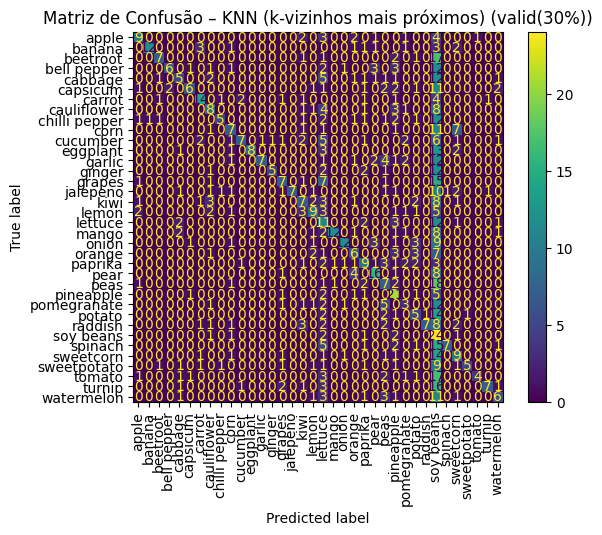


=== Random Forest (floresta aleat√≥ria) @ valid(30%) ===
Acur√°cia (accuracy): 0.3452
F1-macro: 0.3491

Relat√≥rio de classifica√ß√£o (classification report):
               precision    recall  f1-score   support

        apple       0.60      0.39      0.47        23
       banana       0.44      0.60      0.51        25
     beetroot       0.39      0.31      0.35        29
  bell pepper       0.38      0.27      0.31        30
      cabbage       0.27      0.29      0.28        31
     capsicum       0.44      0.23      0.30        30
       carrot       0.38      0.56      0.45        27
  cauliflower       0.30      0.41      0.34        27
chilli pepper       0.25      0.10      0.15        29
         corn       0.27      0.28      0.27        29
     cucumber       0.31      0.32      0.32        31
     eggplant       0.20      0.39      0.26        28
       garlic       0.29      0.29      0.29        31
       ginger       0.83      0.22      0.34        23
       grapes 

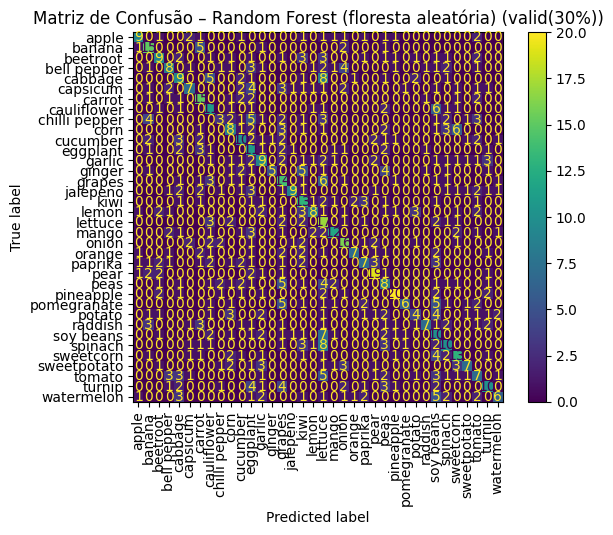


=== MLP (rede neural multicamada) @ valid(30%) ===
Acur√°cia (accuracy): 0.3163
F1-macro: 0.3152

Relat√≥rio de classifica√ß√£o (classification report):
               precision    recall  f1-score   support

        apple       0.44      0.35      0.39        23
       banana       0.48      0.60      0.54        25
     beetroot       0.32      0.28      0.30        29
  bell pepper       0.33      0.33      0.33        30
      cabbage       0.30      0.32      0.31        31
     capsicum       0.35      0.23      0.28        30
       carrot       0.57      0.48      0.52        27
  cauliflower       0.30      0.41      0.34        27
chilli pepper       0.25      0.14      0.18        29
         corn       0.27      0.31      0.29        29
     cucumber       0.31      0.32      0.32        31
     eggplant       0.34      0.39      0.37        28
       garlic       0.33      0.35      0.34        31
       ginger       0.40      0.26      0.32        23
       grapes       

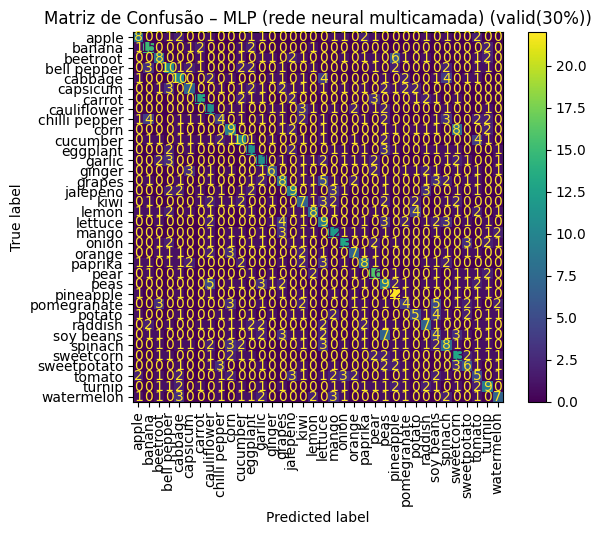


=== KNN (k-vizinhos mais pr√≥ximos) @ test externo ===
Acur√°cia (accuracy): 0.9359
F1-macro: 0.9401

Relat√≥rio de classifica√ß√£o (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       1.00      0.89      0.94         9
     beetroot       1.00      0.90      0.95        10
  bell pepper       0.90      0.90      0.90        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.90      0.95        10
       carrot       1.00      1.00      1.00        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.90      0.95        10
         corn       1.00      0.80      0.89        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      0.90      0.95        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      0.90      0.95        10
       grapes   

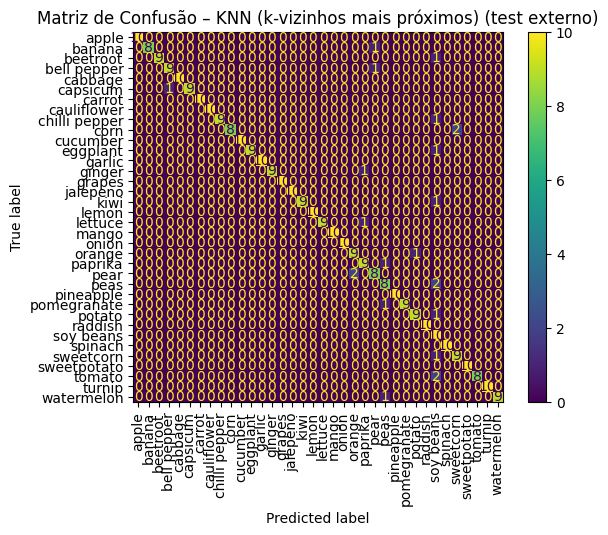


=== Random Forest (floresta aleat√≥ria) @ test externo ===
Acur√°cia (accuracy): 0.9443
F1-macro: 0.9445

Relat√≥rio de classifica√ß√£o (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       1.00      1.00      1.00         9
     beetroot       0.90      0.90      0.90        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       0.91      1.00      0.95        10
     capsicum       1.00      0.90      0.95        10
       carrot       1.00      1.00      1.00        10
  cauliflower       0.91      1.00      0.95        10
chilli pepper       1.00      0.90      0.95        10
         corn       0.89      0.80      0.84        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      0.90      0.95        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      0.90      0.95        10
       grape

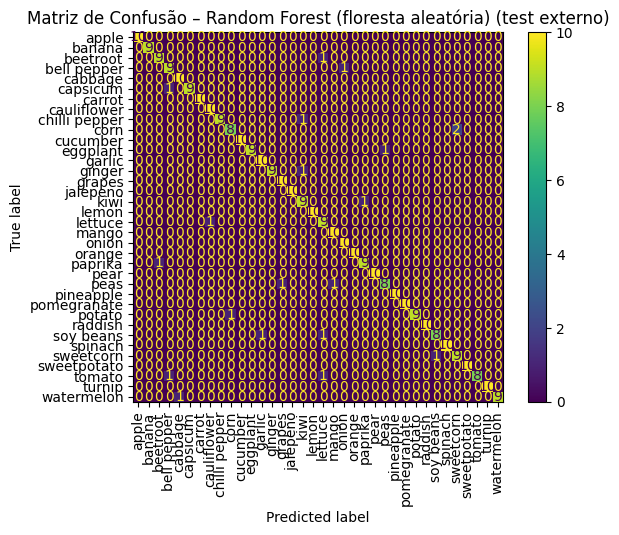


=== MLP (rede neural multicamada) @ test externo ===
Acur√°cia (accuracy): 0.9415
F1-macro: 0.9412

Relat√≥rio de classifica√ß√£o (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       0.90      1.00      0.95         9
     beetroot       0.90      0.90      0.90        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       0.91      1.00      0.95        10
     capsicum       0.90      0.90      0.90        10
       carrot       1.00      1.00      1.00        10
  cauliflower       0.91      1.00      0.95        10
chilli pepper       1.00      0.90      0.95        10
         corn       1.00      0.80      0.89        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      0.90      0.95        10
       garlic       0.83      1.00      0.91        10
       ginger       1.00      0.90      0.95        10
       grapes     

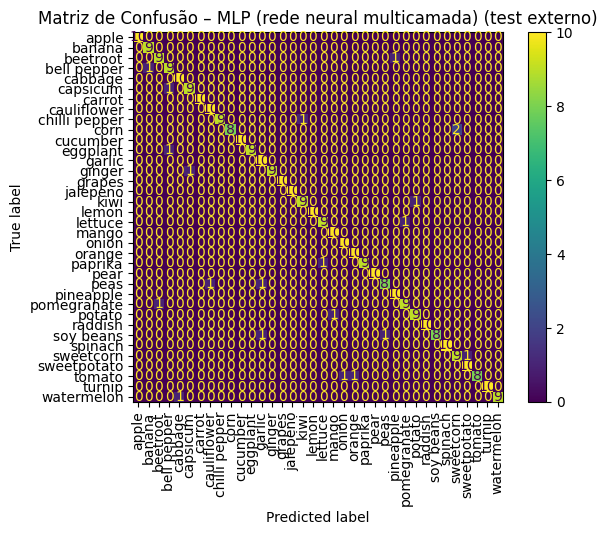


=== Tabela de valida√ß√£o (30%) ===


acc_valid  f1_valid
Random Forest (floresta aleat√≥ria)   0.345192  0.349063
KNN (k-vizinhos mais pr√≥ximos)       0.295192  0.340126
MLP (rede neural multicamada)        0.316346  0.315189


=== Tabela de teste externo ===


acc_test   f1_test
Random Forest (floresta aleat√≥ria)  0.944290  0.944536
MLP (rede neural multicamada)       0.941504  0.941195
KNN (k-vizinhos mais pr√≥ximos)      0.935933  0.940146

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


acc_mean   acc_std   f1_mean    f1_std
Random Forest (floresta aleat√≥ria)  0.341703  0.021527  0.339111  0.021420
KNN (k-vizinhos mais pr√≥ximos)      0.299567  0.016991  0.338874  0.023460
MLP (rede neural multicamada)       0.321501  0.020293  0.318650  0.020238

In [ ]:
# @title == Relat√≥rios de classifica√ß√£o ==

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def evaluate_split(name, clf, X, y, split_name):
    y_hat = clf.predict(X)
    acc = accuracy_score(y, y_hat)
    f1m = f1_score(y, y_hat, average='macro')
    print(f"\n=== {name} @ {split_name} ===")
    print("Acur√°cia (accuracy):", f"{acc:.4f}")
    print("F1-macro:", f"{f1m:.4f}")
    print("\nRelat√≥rio de classifica√ß√£o (classification report):")
    print(classification_report(y, y_hat))
    cm = confusion_matrix(y, y_hat, labels=np.unique(y))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(xticks_rotation=90)
    plt.title(f"Matriz de Confus√£o ‚Äì {name} ({split_name})")
    plt.show()
    return acc, f1m

results_valid = {}
for name, clf in fitted.items():
    acc, f1m = evaluate_split(name, clf, X_valid, y_valid, "valid(30%)")
    results_valid[name] = {"acc_valid": acc, "f1_valid": f1m}

results_test = {}
if 'X_test_ext' in globals() and X_test_ext is not None and y_test_ext is not None:
    for name, clf in fitted.items():
        acc, f1m = evaluate_split(name, clf, X_test_ext, y_test_ext, "test externo")
        results_test[name] = {"acc_test": acc, "f1_test": f1m}

print("\n=== Tabela de valida√ß√£o (30%) ===")
df_valid = pd.DataFrame(results_valid).T.sort_values(by=["f1_valid","acc_valid"], ascending=False)
display(df_valid)

if results_test:
    print("\n=== Tabela de teste externo ===")
    df_test = pd.DataFrame(results_test).T.sort_values(by=["f1_test","acc_test"], ascending=False)
    display(df_test)

from numpy import vstack, hstack
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"accuracy":"accuracy", "f1_macro":"f1_macro"}
cv_table = {}
for name, clf in models.items():
    scores = cross_validate(clf, vstack([X_train, X_valid]), hstack([y_train, y_valid]),
                            cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    cv_table[name] = {
        "acc_mean": scores["test_accuracy"].mean(),
        "acc_std":  scores["test_accuracy"].std(),
        "f1_mean":  scores["test_f1_macro"].mean(),
        "f1_std":   scores["test_f1_macro"].std()
    }

df_cv = pd.DataFrame(cv_table).T.sort_values(by=["f1_mean","acc_mean"], ascending=False)
display(df_cv)


## 5. Empacotamento do melhor modelo e *stub* de aplicativo Streamlit

Para implanta√ß√£o simples, recomenda-se salvar o **normalizador** (*scaler*) e o **melhor modelo** (crit√©rio por F1-macro) usando `joblib`. O *stub* do Streamlit ilustra o fluxo **upload ‚Üí extra√ß√£o de atributos ‚Üí predi√ß√£o**.


In [ ]:
# @title Sele√ß√£o do melhor modelo (F1-macro) e salvamento no Google Drive
import joblib, os

# Determina o melhor modelo com base no F1 da valida√ß√£o
best_name = max(results_valid, key=lambda k: results_valid[k]["f1_valid"])
best_model = fitted[best_name]
print("Melhor modelo (valida√ß√£o F1-macro):", best_name, "->", results_valid[best_name])

# Caminho alvo no Google Drive
models_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models"
os.makedirs(models_path, exist_ok=True)

# Caminhos completos de destino
scaler_path = os.path.join(models_path, "scaler.joblib")
model_path = os.path.join(models_path, "best_model.joblib")

# Salvamento dos artefatos
joblib.dump(scaler, scaler_path)
joblib.dump(best_model, model_path)

print(f"‚úÖ Artefatos salvos com sucesso em:\n{models_path}")



Melhor modelo (valida√ß√£o F1-macro): Random Forest (floresta aleat√≥ria) -> {'acc_valid': 0.3451923076923077, 'f1_valid': 0.3490630717495844}
‚úÖ Artefatos salvos com sucesso em:
/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models


# üß™ Modo silencioso ‚Äî teste sem interface Streamlit (

In [ ]:
# @title Verifica que os arquivos dos modelos est√£o no Google Drive
import os

models_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models"
for f in os.listdir(models_path):
    print("üìÑ", f, f"({os.path.getsize(os.path.join(models_path, f))/1024:.1f} KB)")


üìÑ best_model.joblib (179669.3 KB)
üìÑ best_model_pipeline.joblib (179859.8 KB)
üìÑ metadata.json (0.8 KB)
üìÑ scaler.joblib (190.5 KB)


In [ ]:
"""
# @title Teste silencioso da pipeline de predi√ß√£o (sem Streamlit)
import joblib, cv2, numpy as np
from skimage.feature import hog
from PIL import Image

# Carrega os artefatos
scaler = joblib.load(os.path.join(models_path, "scaler.joblib"))
model  = joblib.load(os.path.join(models_path, "best_model.joblib"))

# Fun√ß√µes de feature extraction
def rgb_mean_feature(img):
    return img.mean(axis=(0,1))

def hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    feat = hog(
        gray, orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys', transform_sqrt=True, feature_vector=True
    )
    return feat

# Caminho de uma imagem para teste
# (substitui pelo caminho de uma imagem existente no Drive)
img_path = \
"/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/images_from_internet/cauliflower_2.jpg"

# Leitura e pr√©-processamento
img = np.array(Image.open(img_path).convert("RGB"))
img_resized = cv2.resize(img, (128, 128))
f_rgb = rgb_mean_feature(img_resized)
f_hog = hog_feature(img_resized)
feats = np.hstack([f_rgb, f_hog]).reshape(1, -1)

# Normaliza e prediz
feats = scaler.transform(feats)
pred = model.predict(feats)[0]

print(f"‚úÖ Classe predita: {pred}")
"""

'\n# @title Teste silencioso da pipeline de predi√ß√£o (sem Streamlit)\nimport joblib, cv2, numpy as np\nfrom skimage.feature import hog\nfrom PIL import Image\n\n# Carrega os artefatos\nscaler = joblib.load(os.path.join(models_path, "scaler.joblib"))\nmodel  = joblib.load(os.path.join(models_path, "best_model.joblib"))\n\n# Fun√ß√µes de feature extraction\ndef rgb_mean_feature(img):\n    return img.mean(axis=(0,1))\n\ndef hog_feature(img):\n    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\n    feat = hog(\n        gray, orientations=9,\n        pixels_per_cell=(8,8),\n        cells_per_block=(2,2),\n        block_norm=\'L2-Hys\', transform_sqrt=True, feature_vector=True\n    )\n    return feat\n\n# Caminho de uma imagem para teste\n# (substitui pelo caminho de uma imagem existente no Drive)\nimg_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/images_from_internet/cauliflower_2.jpg"\n\n# Leitura e pr√©-processamento\nimg = np.array(Image.open(img_path).convert("RGB"))

Instala pacote (quando necess√°rio)

In [ ]:
!pip install -q streamlit

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10.1/10.1 MB 43.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6.9/6.9 MB 56.2 MB/s eta 0:00:00


In [ ]:
# app_Fruits_Veggies_streamlit_stub.py
import streamlit as st
import numpy as np, cv2
from PIL import Image
import joblib
from skimage.feature import hog
import os # Import os to join paths

st.title("Classificador de Frutas, Legumes e Verduras üçéü•ï")

# Path to models in Google Drive
#models_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models"
scaler = joblib.load(os.path.join(models_path, "scaler.joblib"))
model  = joblib.load(os.path.join(models_path, "best_model.joblib"))

def rgb_mean_feature(img):
    return img.mean(axis=(0,1))

def hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    feat = hog(
        gray, orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys', transform_sqrt=True, feature_vector=True
    )
    return feat

uploaded = st.file_uploader("Envie uma imagem (.jpg/.png)", type=["jpg","jpeg","png"])
if uploaded:
    pil = Image.open(uploaded).convert("RGB")
    img = np.array(pil)
    img_resized = cv2.resize(img, (128, 128))
    f_rgb = rgb_mean_feature(img_resized)
    f_hog = hog_feature(img_resized)
    feats = np.hstack([f_rgb, f_hog]).reshape(1, -1)
    feats = scaler.transform(feats)
    pred = model.predict(feats)[0]
    st.image(pil, caption=f"Predi√ß√£o: {pred}", use_container_width=True)

2025-10-17 12:14:58.960 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:14:59.178 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-17 12:14:59.182 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:14:59.183 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:15:00.512 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:15:00.514 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:15:00.515 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:15:00.517 Thread 'MainThread': mi

In [ ]:
!streamlit run app_Fruits_Veggies_streamlit_stub.py --server.port 8501


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app_Fruits_Veggies_streamlit_stub.py



## 6. Conclus√µes, *trade-offs* (compensa√ß√µes) e trabalhos futuros

- **KNN (k-vizinhos mais pr√≥ximos):** interpreta√ß√£o simples; custo de predi√ß√£o cresce com amostra; sens√≠vel √† escala.  
- **√Årvore de Decis√£o:** interpret√°vel; risco de sobreajuste (*overfitting*) isolada.  
- **Regress√£o Log√≠stica:** baseline competitivo para multiclasse; requer atributos informativos.  
- **Random Forest (floresta aleat√≥ria):** robusta; bom desempenho geral; menos interpret√°vel que √°rvore √∫nica.  
- **Bagging (agrega√ß√£o por *bootstrap*):** reduz vari√¢ncia; favorece estimadores inst√°veis.  
- **Boosting (AdaBoost):** corrige erros sequenciais; sens√≠vel a ru√≠do e hiperpar√¢metros.  
- **MLP (rede neural multicamada):** modela n√£o linearidades; demanda ajuste fino e, por vezes, mais dados.

**Futuros:** *data augmentation*, PCA, calibra√ß√£o de probabilidades e explora√ß√£o de CNN em trabalho posterior.



## 7. Refer√™ncias

- Kelleher, J. D.; Mac Namee, B.; D‚ÄôArcy, A. (2020). *Fundamentals of Machine Learning for Predictive Data Analytics (2nd ed.).* MIT Press.  
- Documenta√ß√£o do scikit-learn e scikit-image.



# üìå Corre√ß√µes de Compatibilidade ‚Äî Vers√£o 2.5

Implementaram-se ajustes m√≠nimos para assegurar **compatibilidade entre treino e aplica√ß√£o** sem reescrever os *snippets* existentes. Inclui:
- par√¢metros can√¥nicos de *feature engineering* (RGB + HOG);
- diagn√≥stico de compatibilidade entre o vetor de *features* e o modelo salvo;
- salvamento de `metadata.json` com par√¢metros e classes;
- op√ß√£o de salvar um `Pipeline` com `StandardScaler` interno.


### 2.5.1 Par√¢metros can√¥nicos e fun√ß√µes de *feature engineering*

In [ ]:

FEAT_RESIZE = (128, 128)
HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    transform_sqrt=True,
    feature_vector=True,
)

import numpy as np, cv2
from skimage.feature import hog

def rgb_mean_feature(img: np.ndarray) -> np.ndarray:
    return img.mean(axis=(0, 1))

def hog_feature(img: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return hog(gray, **HOG_PARAMS)


### 2.5.2 Diagn√≥stico de compatibilidade (*feature length* vs. `n_features_in_`)

In [ ]:

import numpy as np, os, joblib

MODELS_DIR = globals().get("MODELS_DIR", "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models")
os.makedirs(MODELS_DIR, exist_ok=True)

scaler_path = os.path.join(MODELS_DIR, "scaler.joblib")
model_path  = os.path.join(MODELS_DIR, "best_model.joblib")
scaler = joblib.load(scaler_path) if os.path.exists(scaler_path) else None
model  = joblib.load(model_path)  if os.path.exists(model_path)  else None

expected = getattr(model, "n_features_in_", None) if model is not None else None

dummy = np.zeros((FEAT_RESIZE[0], FEAT_RESIZE[1], 3), dtype=np.uint8)
feat_len = len(np.hstack([rgb_mean_feature(dummy), hog_feature(dummy)]))

print("MODELS_DIR:", MODELS_DIR)
print("feat_len (can√¥nico):", feat_len)
print("n_features_in_ (modelo):", expected)
print("‚úì OK" if (expected is None or feat_len == expected) else "‚ö†Ô∏è Incompatibilidade detectada!")


MODELS_DIR: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models
feat_len (can√¥nico): 8103
n_features_in_ (modelo): 8103
‚úì OK


### 2.5.3 Metadados e artefatos (legado + pipeline opcional)

In [ ]:

import os, json, joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

os.makedirs(MODELS_DIR, exist_ok=True)

metadata = {
    "resize": list(FEAT_RESIZE),
    "hog": {
        "orientations": HOG_PARAMS["orientations"],
        "pixels_per_cell": list(HOG_PARAMS["pixels_per_cell"]),
        "cells_per_block": list(HOG_PARAMS["cells_per_block"]),
        "block_norm": HOG_PARAMS["block_norm"],
        "transform_sqrt": HOG_PARAMS["transform_sqrt"],
    },
    "feature_length": int(len(np.hstack([rgb_mean_feature(np.zeros((FEAT_RESIZE[0],FEAT_RESIZE[1],3),dtype=np.uint8)), hog_feature(np.zeros((FEAT_RESIZE[0],FEAT_RESIZE[1],3),dtype=np.uint8))]))),
    "classes": list(getattr(model, "classes_", [])) if model is not None else [],
}
with open(os.path.join(MODELS_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)
print("‚úì metadata.json salvo em", MODELS_DIR)

if "X_train" in globals() and "y_train" in globals():
    base_model = model
    if base_model is None:
        from sklearn.ensemble import RandomForestClassifier
        base_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
        print("‚ÑπÔ∏è Treinando RandomForest de exemplo para compor o pipeline (modelo anterior n√£o encontrado).")
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", base_model)])
    try:
        pipe.fit(X_train, y_train)
        joblib.dump(pipe, os.path.join(MODELS_DIR, "best_model_pipeline.joblib"))
        print("‚úì Pipeline salvo em best_model_pipeline.joblib")
    except Exception as e:
        print("‚ö†Ô∏è Falha ao treinar/salvar pipeline:", e)
else:
    print("‚ÑπÔ∏è X_train/y_train n√£o encontrados ‚Äî pulando cria√ß√£o do pipeline.")


‚úì metadata.json salvo em /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models
‚úì Pipeline salvo em best_model_pipeline.joblib



### 2.5.4 Notas ao aplicativo Streamlit
- O app existente pode continuar utilizando `scaler.joblib` + `best_model.joblib` sem altera√ß√µes.
- Passa a existir tamb√©m `metadata.json` (para valida√ß√£o de compatibilidade) e, opcionalmente, `best_model_pipeline.joblib`, que unifica *scaler* + modelo.



# üîß Corre√ß√µes finais ‚Äî v2.7 (execu√ß√£o interativa padronizada)

Esta se√ß√£o **mant√©m os conte√∫dos existentes** e **apenas acrescenta** *snippets* de execu√ß√£o robustos, padronizando:
- nome do aplicativo: **`app_Fruits_Veggies_streamlit_stub.py`** (renomeia automaticamente se existir em min√∫sculas);
- caminho absoluto: `/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app`;
- execu√ß√£o **headless** do Streamlit com *flags* recomendadas;
- cria√ß√£o de t√∫nel **Cloudflared** e captura autom√°tica da URL p√∫blica (`https://...trycloudflare.com`);
- blocos de **diagn√≥stico** (logs).

> Observa√ß√£o: nenhuma c√©lula anterior foi removida; esta se√ß√£o substitui e corrige apenas a execu√ß√£o.


## v2.7.1 Caminhos can√¥nicos do projeto

In [ ]:

# @title Caminhos (v2.7)
import os
BASE_DIR = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies"
APP_DIR = os.path.join(BASE_DIR, "app")
MODELS_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(APP_DIR, exist_ok=True); os.makedirs(MODELS_DIR, exist_ok=True)

APP_CAMEL = os.path.join(APP_DIR, "app_Fruits_Veggies_streamlit_stub.py")
APP_LOWER = os.path.join(APP_DIR, "app_fruits_veggies_streamlit_stub.py")

print("BASE_DIR:", BASE_DIR)
print("APP_DIR:", APP_DIR)
print("MODELS_DIR:", MODELS_DIR)
print("APP_CAMEL:", APP_CAMEL)
print("APP_LOWER:", APP_LOWER)


BASE_DIR: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies
APP_DIR: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app
MODELS_DIR: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models
APP_CAMEL: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app/app_Fruits_Veggies_streamlit_stub.py
APP_LOWER: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app/app_fruits_veggies_streamlit_stub.py


## v2.7.2 Padroniza√ß√£o do nome do app

In [ ]:

# @title Renomeia app para nome can√¥nico se necess√°rio
import os, shutil

if os.path.exists(APP_LOWER):
    # Garante que a vers√£o can√¥nica seja a ativa
    if os.path.exists(APP_CAMEL):
        os.remove(APP_CAMEL)
    shutil.move(APP_LOWER, APP_CAMEL)
    print("‚úì Renomeado para:", APP_CAMEL)
else:
    print("‚ÑπÔ∏è Arquivo em min√∫sculas n√£o encontrado; mantendo:", APP_CAMEL)

print("Existe APP_CAMEL?", os.path.exists(APP_CAMEL))


‚ÑπÔ∏è Arquivo em min√∫sculas n√£o encontrado; mantendo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app/app_Fruits_Veggies_streamlit_stub.py
Existe APP_CAMEL? True


## v2.7.3 Verifica√ß√£o dos artefatos do modelo

In [ ]:

# @title Checagem de artefatos (modelo/scaler)
import glob, os
arts = glob.glob(os.path.join(MODELS_DIR, "*.joblib")) + glob.glob(os.path.join(MODELS_DIR, "*.json"))
print("Artefatos encontrados:", arts)

if not os.path.exists(os.path.join(MODELS_DIR, "scaler.joblib")):
    print("‚ö†Ô∏è scaler.joblib ausente.")
if not (os.path.exists(os.path.join(MODELS_DIR, "best_model.joblib")) or os.path.exists(os.path.join(MODELS_DIR, "best_model_pipeline.joblib"))):
    print("‚ö†Ô∏è best_model(.joblib|_pipeline.joblib) ausente.")


Artefatos encontrados: ['/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models/best_model.joblib', '/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models/best_model_pipeline.joblib', '/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models/scaler.joblib', '/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models/metadata.json']


## v2.7.4 Execu√ß√£o headless + Cloudflared (URL p√∫blica)

In [ ]:

# @title Subir Streamlit + Cloudflared (v2.7)
# 1) Mata processos antigos
!pkill -f streamlit || true
!pkill -f cloudflared || true

# 2) Inicia Streamlit (headless) em background
!streamlit run "$APP_DIR/app_Fruits_Veggies_streamlit_stub.py"   --server.port 8501   --server.headless true   --server.enableCORS false   --server.enableXsrfProtection false   --browser.gatherUsageStats false &> streamlit.log &
print("‚úì Streamlit iniciado em background.")

# 3) Baixa e executa Cloudflared
!wget -q -O cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared
!./cloudflared tunnel --url http://localhost:8501 --no-autoupdate &> cloudflared.log &
print("‚úì Cloudflared iniciando...")


^C
^C
‚úì Streamlit iniciado em background.
‚úì Cloudflared iniciando...


In [ ]:

# @title Captura autom√°tica da URL p√∫blica
import re, time
for _ in range(30):
    time.sleep(1.0)
    try:
        log = open("cloudflared.log").read()
    except Exception:
        log = ""
    m = re.search(r"https://[a-z0-9-]+\.trycloudflare\.com", log)
    if m:
        print("üåç URL p√∫blica:", m.group(0))
        break
else:
    print("‚ö†Ô∏è N√£o foi poss√≠vel capturar a URL automaticamente. Rode: !tail -n 200 cloudflared.log")


üåç URL p√∫blica: https://donation-chelsea-concentrations-guys.trycloudflare.com


## v2.7.5 Diagn√≥stico r√°pido (logs)

In [ ]:

# @title Logs (Streamlit e Cloudflared)
print("‚Äî √öltimas linhas do Streamlit ‚Äî");
!tail -n 80 streamlit.log || true
print("\n‚Äî √öltimas linhas do Cloudflared ‚Äî");
!tail -n 120 cloudflared.log || true


‚Äî √öltimas linhas do Streamlit ‚Äî

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.67.184.176:8501


‚Äî √öltimas linhas do Cloudflared ‚Äî
2025-10-17T12:18:31Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-10-17T12:18:31Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-10-17T12:18:34Z INF +--------------------------------------------